In [1]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Thesis pipeline utilities
from thesis_pipeline.io.paths import get_data_path
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load Topic Definitions and Embeddings

Load the validated topic metadata from notebook 15a.

In [3]:
# Paths
topics_input_path = workspace_root / 'data' / '02_topics' / 'reddit'
corpus_path = get_data_path('qa', 'reddit')
output_path = workspace_root / 'data' / '02_topics' / 'reddit'
output_path.mkdir(parents=True, exist_ok=True)

print(f"Topics input: {topics_input_path}")
print(f"Corpus input: {corpus_path}")
print(f"Output: {output_path}")

# Check files exist
print(f"\nValidating input files:")
print(f"  Topic definitions: {(topics_input_path / 'topic_definitions.json').exists()}")
print(f"  Topic embeddings: {(topics_input_path / 'topic_embeddings.npy').exists()}")
print(f"  Thread pseudodocs: {(corpus_path / 'thread_pseudodocs.parquet').exists()}")
print(f"  Comment-thread map: {(corpus_path / 'comment_thread_map.parquet').exists()}")

Topics input: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit
Corpus input: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/03_qa/reddit
Output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit

Validating input files:
  Topic definitions: True
  Topic embeddings: True
  Thread pseudodocs: True
  Comment-thread map: True


In [4]:
# Load topic definitions
with open(topics_input_path / 'topic_definitions.json', 'r') as f:
    topic_definitions = json.load(f)

print(f"Loaded {len(topic_definitions)} topic definitions:")
for topic_id, topic_info in topic_definitions.items():
    print(f"  {topic_id}: {topic_info['label']}")

Loaded 5 topic definitions:
  climate_change: Climate Change
  donald_trump: Donald Trump
  gun_control: Gun Control
  immigration: Immigration
  vaccination: Vaccination


In [5]:
# Load topic embeddings
topic_embeddings_matrix = np.load(topics_input_path / 'topic_embeddings.npy')

with open(topics_input_path / 'topic_ids.json', 'r') as f:
    topic_ids_list = json.load(f)

# Convert to dictionary
topic_embeddings = {
    tid: topic_embeddings_matrix[idx]
    for idx, tid in enumerate(topic_ids_list)
}

print(f"Loaded topic embeddings:")
print(f"  Shape: {topic_embeddings_matrix.shape}")
print(f"  Topics: {', '.join(topic_ids_list)}")

Loaded topic embeddings:
  Shape: (5, 384)
  Topics: climate_change, donald_trump, gun_control, immigration, vaccination


In [6]:
# Set validated threshold from notebook 15a
THRESHOLD = 0.4  # Empirically validated - retains 8.5% of corpus with good quality

print(f"Using threshold: {THRESHOLD}")
print(f"Expected retention: ~8.5% of corpus")
print(f"Expected reduction: ~91.5% of off-topic content")

Using threshold: 0.4
Expected retention: ~8.5% of corpus
Expected reduction: ~91.5% of off-topic content


## 2. Load Full Corpus

Load all thread pseudodocs and comment-thread mapping.

In [7]:
# Load thread pseudodocs
print("Loading thread pseudo-documents...")
df_threads = read_parquet(corpus_path / 'thread_pseudodocs.parquet')

print(f"\nLoaded {len(df_threads):,} thread pseudo-documents")
print(f"Columns: {df_threads.columns.tolist()}")

# Date range
dates = pd.to_datetime(df_threads['created_utc'], unit='s')
print(f"\nDate range: {dates.min().date()} to {dates.max().date()}")

# Comment statistics
print(f"\nComment statistics:")
print(f"  Total comments: {df_threads['n_comments'].sum():,}")
print(f"  Mean comments/thread: {df_threads['n_comments'].mean():.1f}")
print(f"  Median comments/thread: {df_threads['n_comments'].median():.0f}")

Loading thread pseudo-documents...

Loaded 433,973 thread pseudo-documents
Columns: ['submission_id', 'title', 'selftext', 'n_comments', 'pseudodoc_text', 'pseudodoc_length', 'pseudodoc_tokens_approx', 'title_length', 'selftext_length', 'created_utc', 'subreddit', 'subreddit_id']

Date range: 2016-09-01 to 2016-10-31

Comment statistics:
  Total comments: 8,518,578
  Mean comments/thread: 19.6
  Median comments/thread: 3


## 3. Load Embedding Model

Load the same model used in notebook 15a for consistency.

In [10]:
# Load sentence embedding model
print("Loading sentence embedding model...")
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

print(f"✓ Loaded model: {model_name}")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Max sequence length: {model.max_seq_length}")

# Check for GPU
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
if device == 'cuda':
    model = model.to(device)
    print(f"  Device: {device} (GPU acceleration enabled)")
elif device == 'mps':
    model = model.to(device)
    print(f"  Device: {device} (Apple Silicon GPU acceleration enabled)")
else:
    print(f"  Device: {device} (CPU - this will take longer)")

Loading sentence embedding model...
✓ Loaded model: sentence-transformers/all-MiniLM-L6-v2
  Embedding dimension: 384
  Max sequence length: 256
  Device: mps (Apple Silicon GPU acceleration enabled)


## 4. Embed All Documents

Create embeddings for all thread pseudodocs. This will take ~30-60 minutes depending on hardware.

**Note**: We use title + first 500 chars of pseudodoc (same as 15a) for consistency.

In [11]:
# Prepare texts for embedding
print("Preparing texts for embedding...")

# Use title + first 500 chars (same as 15a for consistency)
texts_to_embed = (
    df_threads['title'] + ' ' + 
    df_threads['pseudodoc_text'].str[:500]
).tolist()

print(f"Prepared {len(texts_to_embed):,} texts")
print(f"\nExample text (first 200 chars):")
print(f"{texts_to_embed[0][:200]}...")

Preparing texts for embedding...
Prepared 433,973 texts

Example text (first 200 chars):
When is the speech? When is the speech?  I thought it was at 7 pm? like right now!...


In [14]:
# Embed all documents
print(f"\nEmbedding {len(texts_to_embed):,} documents...")
print("This will take approximately 30-60 minutes.\n")

# Use large batch size for efficiency
BATCH_SIZE = 128

doc_embeddings = model.encode(
    texts_to_embed,
    batch_size=BATCH_SIZE,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True  # Normalize for cosine similarity
)

print(f"\n✓ Created embeddings for {len(doc_embeddings):,} documents")
print(f"  Embedding shape: {doc_embeddings.shape}")
print(f"  Memory usage: {doc_embeddings.nbytes / 1e9:.2f} GB")


Embedding 433,973 documents...
This will take approximately 30-60 minutes.



Batches:   0%|          | 0/3391 [00:00<?, ?it/s]


✓ Created embeddings for 433,973 documents
  Embedding shape: (433973, 384)
  Memory usage: 0.67 GB


In [15]:
# Save embeddings for potential re-use
embeddings_file = output_path / 'thread_embeddings_full.npy'
np.save(embeddings_file, doc_embeddings)

print(f"✓ Saved document embeddings: {embeddings_file}")
print(f"  Can be reloaded to skip embedding step in future runs")

✓ Saved document embeddings: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/thread_embeddings_full.npy
  Can be reloaded to skip embedding step in future runs


## 5. Compute Topic Similarity Scores

Calculate cosine similarity between each document and all 5 topics.

In [16]:
# Compute similarity scores for each topic
print("Computing similarity scores for each topic...\n")

for topic_id, topic_embedding in topic_embeddings.items():
    topic_label = topic_definitions[topic_id]['label']
    
    print(f"Processing: {topic_label}...")
    
    # Compute cosine similarity
    similarities = cosine_similarity(
        doc_embeddings, 
        topic_embedding.reshape(1, -1)
    ).flatten()
    
    # Add to dataframe
    df_threads[f'sim_{topic_id}'] = similarities
    
    # Statistics
    above_thresh = (similarities >= THRESHOLD).sum()
    pct = above_thresh / len(similarities) * 100
    
    print(f"  Mean similarity: {similarities.mean():.3f}")
    print(f"  Above threshold ({THRESHOLD}): {above_thresh:,} ({pct:.1f}%)\n")

print("✓ Computed similarity scores for all topics")

Computing similarity scores for each topic...

Processing: Climate Change...
  Mean similarity: 0.056
  Above threshold (0.4): 1,391 (0.3%)

Processing: Donald Trump...
  Mean similarity: 0.250
  Above threshold (0.4): 29,559 (6.8%)

Processing: Gun Control...
  Mean similarity: 0.077
  Above threshold (0.4): 2,988 (0.7%)

Processing: Immigration...
  Mean similarity: 0.136
  Above threshold (0.4): 3,656 (0.8%)

Processing: Vaccination...
  Mean similarity: 0.075
  Above threshold (0.4): 122 (0.0%)

✓ Computed similarity scores for all topics


## 6. Assign Topics to Threads

For each thread, assign the topic with the highest similarity score (if above threshold).

In [17]:
# Find best matching topic for each thread
print(f"Assigning topics to threads (threshold = {THRESHOLD})...\n")

# Get all similarity columns
sim_cols = [f'sim_{topic_id}' for topic_id in topic_definitions.keys()]

# Find max similarity and corresponding topic
df_threads['max_similarity'] = df_threads[sim_cols].max(axis=1)
df_threads['best_topic_idx'] = df_threads[sim_cols].idxmax(axis=1)

# Map back to topic ID
topic_id_list = list(topic_definitions.keys())
df_threads['best_topic'] = df_threads['best_topic_idx'].apply(
    lambda x: topic_id_list[sim_cols.index(x)] if pd.notna(x) else None
)

# Apply threshold filter
df_threads['topic_id'] = df_threads.apply(
    lambda row: row['best_topic'] if row['max_similarity'] >= THRESHOLD else None,
    axis=1
)

# Statistics
assigned = df_threads['topic_id'].notna().sum()
unassigned = df_threads['topic_id'].isna().sum()
assigned_pct = assigned / len(df_threads) * 100

print(f"Assignment results:")
print(f"  Threads with topic (>= {THRESHOLD}): {assigned:,} ({assigned_pct:.1f}%)")
print(f"  Threads without topic (< {THRESHOLD}): {unassigned:,} ({100-assigned_pct:.1f}%)")

print(f"\nTopic distribution:")
topic_counts = df_threads['topic_id'].value_counts()
for topic_id, count in topic_counts.items():
    topic_label = topic_definitions[topic_id]['label']
    pct = count / assigned * 100
    print(f"  {topic_label}: {count:,} ({pct:.1f}% of assigned)")

Assigning topics to threads (threshold = 0.4)...

Assignment results:
  Threads with topic (>= 0.4): 37,382 (8.6%)
  Threads without topic (< 0.4): 396,591 (91.4%)

Topic distribution:
  Donald Trump: 29,334 (78.5% of assigned)
  Immigration: 3,587 (9.6% of assigned)
  Gun Control: 2,969 (7.9% of assigned)
  Climate Change: 1,379 (3.7% of assigned)
  Vaccination: 113 (0.3% of assigned)


## 7. Filter to Topic-Assigned Threads

Keep only threads that were assigned to a topic.

In [35]:
# Filter to assigned threads only
df_threads_filtered = df_threads[df_threads['topic_id'].notna()].copy()

print(f"Filtered corpus:")
print(f"  Original: {len(df_threads):,} threads")
print(f"  Filtered: {len(df_threads_filtered):,} threads")
print(f"  Reduction: {(1 - len(df_threads_filtered)/len(df_threads))*100:.1f}%")

# Comment statistics
comments_kept = df_threads_filtered['n_comments'].sum()
comments_total = df_threads['n_comments'].sum()

print(f"\nComment statistics:")
print(f"  Original: {comments_total:,} comments")
print(f"  Filtered: {comments_kept:,} comments")
print(f"  Reduction: {(1 - comments_kept/comments_total)*100:.1f}%")

Filtered corpus:
  Original: 433,973 threads
  Filtered: 37,382 threads
  Reduction: 91.4%

Comment statistics:
  Original: 8,518,578 comments
  Filtered: 1,229,381 comments
  Reduction: 85.6%


## 8. Load Complete Gold Data

Load full comments and submissions from gold tables (with complete data including text).

In [36]:
# Load all gold comments from monthly parquet files
print("Loading gold comments from all months...")

gold_comments_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'comments'
comment_files = sorted(gold_comments_path.glob('*.parquet'))

print(f"Found {len(comment_files)} monthly comment files")

comments_dfs = []
for file in tqdm(comment_files, desc="Loading comments"):
    df_month = read_parquet(file)
    comments_dfs.append(df_month)

df_all_comments = pd.concat(comments_dfs, ignore_index=True)

print(f"\n✓ Loaded {len(df_all_comments):,} total comments")
print(f"  Columns: {df_all_comments.columns.tolist()}")

Loading gold comments from all months...
Found 2 monthly comment files


Loading comments:   0%|          | 0/2 [00:00<?, ?it/s]


✓ Loaded 8,698,923 total comments
  Columns: ['comment_id', 'submission_id', 'created_utc', 'subreddit_id', 'subreddit', 'body']


In [37]:
# Load all gold submissions from monthly parquet files
print("Loading gold submissions from all months...")

gold_submissions_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'submissions'
submission_files = sorted(gold_submissions_path.glob('*.parquet'))

print(f"Found {len(submission_files)} monthly submission files")

submissions_dfs = []
for file in tqdm(submission_files, desc="Loading submissions"):
    df_month = read_parquet(file)
    submissions_dfs.append(df_month)

df_all_submissions = pd.concat(submissions_dfs, ignore_index=True)

print(f"\n✓ Loaded {len(df_all_submissions):,} total submissions")
print(f"  Columns: {df_all_submissions.columns.tolist()}")

Loading gold submissions from all months...
Found 2 monthly submission files


Loading submissions:   0%|          | 0/2 [00:00<?, ?it/s]


✓ Loaded 923,431 total submissions
  Columns: ['submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id', 'subreddit', 'num_comments']


In [38]:
# Create submission_id -> topic_id mapping from filtered threads
print("Creating topic mapping...")

thread_topic_map = df_threads_filtered.set_index('submission_id')['topic_id'].to_dict()
thread_similarity_map = df_threads_filtered.set_index('submission_id')['max_similarity'].to_dict()

print(f"Created mapping for {len(thread_topic_map):,} topic-assigned threads")

# Add topic_id to comments based on their submission
print("\nFiltering comments to topic-assigned threads...")
df_all_comments['topic_id'] = df_all_comments['submission_id'].map(thread_topic_map)

# Filter to comments with topics
df_comments_filtered = df_all_comments[df_all_comments['topic_id'].notna()].copy()

print(f"\nFiltered comments:")
print(f"  Original: {len(df_all_comments):,} comments")
print(f"  Filtered: {len(df_comments_filtered):,} comments")
print(f"  Retention: {len(df_comments_filtered)/len(df_all_comments)*100:.1f}%")
print(f"  Reduction: {(1 - len(df_comments_filtered)/len(df_all_comments))*100:.1f}%")

# Add topic_id and similarity to submissions
print("\nFiltering submissions to topic-assigned threads...")
df_all_submissions['topic_id'] = df_all_submissions['submission_id'].map(thread_topic_map)
df_all_submissions['max_similarity'] = df_all_submissions['submission_id'].map(thread_similarity_map)

# Filter to submissions with topics
df_submissions_filtered = df_all_submissions[df_all_submissions['topic_id'].notna()].copy()

print(f"\nFiltered submissions:")
print(f"  Original: {len(df_all_submissions):,} submissions")
print(f"  Filtered: {len(df_submissions_filtered):,} submissions")
print(f"  Retention: {len(df_submissions_filtered)/len(df_all_submissions)*100:.1f}%")
print(f"  Reduction: {(1 - len(df_submissions_filtered)/len(df_all_submissions))*100:.1f}%")

# Verify match with thread statistics
print(f"\nVerification:")
print(f"  Expected threads (from topic assignment): {len(df_threads_filtered):,}")
print(f"  Actual submissions (from gold): {len(df_submissions_filtered):,}")
print(f"  Match: {'✓' if abs(len(df_submissions_filtered) - len(df_threads_filtered)) < 100 else '✗'}")

Creating topic mapping...
Created mapping for 37,382 topic-assigned threads

Filtering comments to topic-assigned threads...

Filtered comments:
  Original: 8,698,923 comments
  Filtered: 1,244,389 comments
  Retention: 14.3%
  Reduction: 85.7%

Filtering submissions to topic-assigned threads...

Filtered submissions:
  Original: 923,431 submissions
  Filtered: 37,382 submissions
  Retention: 4.0%
  Reduction: 96.0%

Verification:
  Expected threads (from topic assignment): 37,382
  Actual submissions (from gold): 37,382
  Match: ✓


## 9. Prepare Output Datasets

Prepare final datasets with all available columns from gold tables.

In [39]:
# Prepare submissions dataset
print("Preparing submissions dataset...")

# Use filtered submissions from gold (already have all columns)
# Ensure we have the required columns
required_cols = ['submission_id', 'topic_id', 'max_similarity']
missing = [col for col in required_cols if col not in df_submissions_filtered.columns]
if missing:
    print(f"Warning: Missing columns: {missing}")

df_submissions = df_submissions_filtered.copy()

print(f"✓ Prepared submissions dataset")
print(f"  {len(df_submissions):,} submissions")
print(f"  {len(df_submissions.columns)} columns: {df_submissions.columns.tolist()}")

Preparing submissions dataset...
✓ Prepared submissions dataset
  37,382 submissions
  9 columns: ['submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id', 'subreddit', 'num_comments', 'topic_id', 'max_similarity']


In [40]:
df_submissions.head()

,submission_id,title,selftext,created_utc,subreddit_id,subreddit,num_comments,topic_id,max_similarity
21,50kcfp,"After 78 dead, 480 shot in a month Chicago gan...",,1472688094,t5_38unr,The_Donald,6,gun_control,0.521513
27,50kcmy,Why Trump's Risky Trip to Mexico Paid Off,,1472688168,t5_3dcgq,ConservativesOnly,1,donald_trump,0.402272
32,50kcrj,Mexican president: I told Trump we wouldn't pa...,,1472688212,t5_2cneq,politics,41,donald_trump,0.411303
73,50kdem,TRANSCRIPT of Historic Mexican President Nieto...,https://www.youtube.com/watch?v=rtt198LweoU\n\...,1472688449,t5_38unr,The_Donald,5,immigration,0.548417
77,50kdjg,Doing Everything He can to Ensure Trump is not...,...apparently means doing absolutely nothing.,1472688496,t5_3fmhe,Enough_Sanders_Spam,9,donald_trump,0.450592


In [41]:
# Prepare comments dataset  
print("Preparing comments dataset...")

# Use filtered comments from gold (already have all columns including body text)
# Ensure we have the required columns
required_cols = ['comment_id', 'submission_id', 'body', 'topic_id']
missing = [col for col in required_cols if col not in df_comments_filtered.columns]
if missing:
    print(f"Warning: Missing columns: {missing}")

df_comments = df_comments_filtered.copy()

print(f"✓ Prepared comments dataset")
print(f"  {len(df_comments):,} comments")
print(f"  {len(df_comments.columns)} columns: {df_comments.columns.tolist()}")
print(f"\nSample comment text (first 200 chars):")
if 'body' in df_comments.columns and len(df_comments) > 0:
    sample_text = df_comments['body'].iloc[0]
    print(f"  {str(sample_text)[:200]}...")
else:
    print("  No body column found!")

Preparing comments dataset...
✓ Prepared comments dataset
  1,244,389 comments
  7 columns: ['comment_id', 'submission_id', 'created_utc', 'subreddit_id', 'subreddit', 'body', 'topic_id']

Sample comment text (first 200 chars):
  
[As a reminder, this subreddit is for civil discussion.](https://www.reddit.com/r/politics/wiki/rulesandregs#wiki_please_be_civil)

* Do not call other users trolls, morons, children, or anything els...


In [42]:
df_comments.head()

,comment_id,submission_id,created_utc,subreddit_id,subreddit,body,topic_id
4,d74qrvh,50kcrj,1472688212,t5_2cneq,politics,"\n[As a reminder, this subreddit is for civil ...",donald_trump
10,d74qu6b,50kcrj,1472688312,t5_2cneq,politics,Question:\n\nTrump said something.\n\nNieto sa...,donald_trump
20,d74qxd2,50kcrj,1472688451,t5_2cneq,politics,"Hopefully one of them has a video. However, th...",donald_trump
24,d74qxsk,50kcrj,1472688470,t5_2cneq,politics,"Trump Supporter:""Sounds like Mexico and it's p...",donald_trump
29,d74qyp0,50kcrj,1472688510,t5_2cneq,politics,Which one has a history of compulsive lying?,donald_trump


## 10. Save Filtered Datasets

Save the topic-filtered submissions and comments.

In [43]:
# Save submissions
submissions_file = output_path / 'submissions_with_topics.parquet'
write_parquet(df_submissions, submissions_file)

print(f"✓ Saved submissions: {submissions_file}")
print(f"  {len(df_submissions):,} rows")
print(f"  {df_submissions.memory_usage(deep=True).sum() / 1e6:.1f} MB")

✓ Wrote 37,382 rows to submissions_with_topics.parquet (5.0 MB)
✓ Saved submissions: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/submissions_with_topics.parquet
  37,382 rows
  23.7 MB


In [44]:
# Save comments
comments_file = output_path / 'comments_with_topics.parquet'
write_parquet(df_comments, comments_file)

print(f"✓ Saved comments: {comments_file}")
print(f"  {len(df_comments):,} rows")
print(f"  {df_comments.memory_usage(deep=True).sum() / 1e6:.1f} MB")

✓ Wrote 1,244,389 rows to comments_with_topics.parquet (161.7 MB)
✓ Saved comments: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/comments_with_topics.parquet
  1,244,389 rows
  709.9 MB


## 11. Generate Statistics and Validation

Create comprehensive statistics and sample threads for validation.

In [45]:
# Topic-level statistics
print("=" * 80)
print("TOPIC-LEVEL STATISTICS")
print("=" * 80)

for topic_id in topic_ids_list:
    topic_label = topic_definitions[topic_id]['label']
    
    # Submissions
    topic_submissions = df_submissions[df_submissions['topic_id'] == topic_id]
    # Comments
    topic_comments = df_comments[df_comments['topic_id'] == topic_id]
    
    print(f"\n{topic_label}:")
    print(f"  Submissions: {len(topic_submissions):,}")
    print(f"  Comments: {len(topic_comments):,}")
    print(f"  Avg comments/submission: {len(topic_comments)/len(topic_submissions):.1f}")
    
    # Date range
    if len(topic_submissions) > 0:
        dates = pd.to_datetime(topic_submissions['created_utc'], unit='s')
        print(f"  Date range: {dates.min().date()} to {dates.max().date()}")
    
    # Top subreddits
    if 'subreddit' in topic_submissions.columns:
        top_subs = topic_submissions['subreddit'].value_counts().head(3)
        print(f"  Top subreddits: {', '.join([f'r/{sub}' for sub in top_subs.index])}")

TOPIC-LEVEL STATISTICS

Climate Change:
  Submissions: 1,379
  Comments: 33,576
  Avg comments/submission: 24.3
  Date range: 2016-09-01 to 2016-10-31
  Top subreddits: r/politics, r/climateskeptics, r/The_Donald

Donald Trump:
  Submissions: 29,334
  Comments: 1,089,926
  Avg comments/submission: 37.2
  Date range: 2016-09-01 to 2016-10-31
  Top subreddits: r/The_Donald, r/politics, r/EnoughTrumpSpam

Gun Control:
  Submissions: 2,969
  Comments: 60,838
  Avg comments/submission: 20.5
  Date range: 2016-09-01 to 2016-10-31
  Top subreddits: r/The_Donald, r/GunsAreCool, r/politics

Immigration:
  Submissions: 3,587
  Comments: 58,655
  Avg comments/submission: 16.4
  Date range: 2016-09-01 to 2016-10-31
  Top subreddits: r/The_Donald, r/politics, r/uncensorednews

Vaccination:
  Submissions: 113
  Comments: 1,394
  Avg comments/submission: 12.3
  Date range: 2016-09-02 to 2016-10-31
  Top subreddits: r/The_Donald, r/politics, r/Libertarian


In [46]:
# Temporal distribution
print("\n" + "=" * 80)
print("TEMPORAL DISTRIBUTION")
print("=" * 80)

df_submissions['date'] = pd.to_datetime(df_submissions['created_utc'], unit='s').dt.date
df_submissions['month'] = pd.to_datetime(df_submissions['created_utc'], unit='s').dt.to_period('M')

print("\nSubmissions by month:")
monthly = df_submissions.groupby('month').size()
print(monthly.head(12))

print("\nSubmissions by topic and month (top 6 months):")
topic_monthly = df_submissions.groupby(['month', 'topic_id']).size().unstack(fill_value=0)
topic_monthly.columns = [topic_definitions[tid]['label'] for tid in topic_monthly.columns]
print(topic_monthly.head(6))


TEMPORAL DISTRIBUTION

Submissions by month:
month
2016-09    15573
2016-10    21809
Freq: M, dtype: int64

Submissions by topic and month (top 6 months):
         Climate Change  Donald Trump  Gun Control  Immigration  Vaccination
month                                                                       
2016-09             715         11022         1698         2075           63
2016-10             664         18312         1271         1512           50


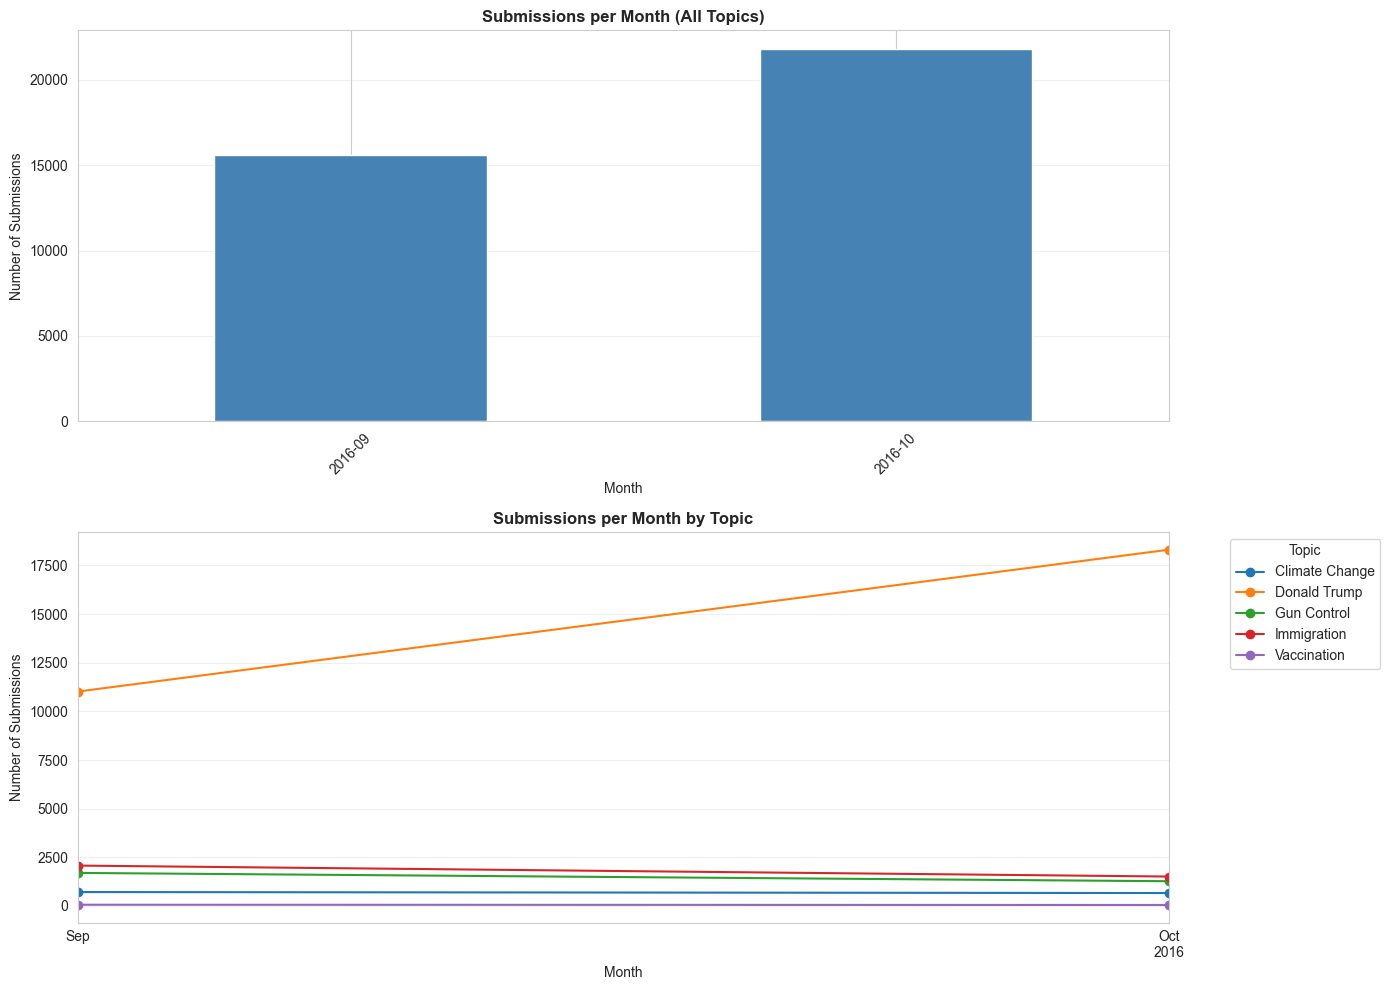

✓ Saved plot: temporal_distribution.png


In [47]:
# Visualize temporal distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Overall temporal distribution
ax1 = axes[0]
monthly_counts = df_submissions.groupby('month').size()
monthly_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Submissions per Month (All Topics)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Submissions')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Per-topic temporal distribution
ax2 = axes[1]
topic_monthly_plot = df_submissions.groupby(['month', 'topic_id']).size().unstack(fill_value=0)
topic_monthly_plot.columns = [topic_definitions[tid]['label'] for tid in topic_monthly_plot.columns]
topic_monthly_plot.plot(kind='line', ax=ax2, marker='o')
ax2.set_title('Submissions per Month by Topic', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Submissions')
ax2.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_path / 'temporal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved plot: temporal_distribution.png")

In [48]:
# Sample threads for validation
print("\n" + "=" * 80)
print("VALIDATION SAMPLES")
print("=" * 80)
print("\nSample threads per topic (5 random per topic):\n")

for topic_id in topic_ids_list:
    topic_label = topic_definitions[topic_id]['label']
    topic_submissions = df_submissions[df_submissions['topic_id'] == topic_id]
    
    if len(topic_submissions) == 0:
        print(f"\n{topic_label}: No submissions")
        continue
    
    print(f"\n{'='*80}")
    print(f"{topic_label.upper()}")
    print(f"{'='*80}")
    
    samples = topic_submissions.sample(n=min(5, len(topic_submissions)), random_state=42)
    
    for idx, (_, row) in enumerate(samples.iterrows(), 1):
        print(f"\n[{idx}] Similarity: {row['max_similarity']:.3f}")
        if 'subreddit' in row:
            print(f"    Subreddit: r/{row['subreddit']}")
        if 'num_comments' in row:
            print(f"    Comments: {row['num_comments']}")
        print(f"    Title: {row['title']}")
        if 'selftext' in row and pd.notna(row['selftext']) and len(str(row['selftext'])) > 0:
            selftext = str(row['selftext'])[:200]
            print(f"    Body: {selftext}...")
        print("-" * 80)


VALIDATION SAMPLES

Sample threads per topic (5 random per topic):


CLIMATE CHANGE

[1] Similarity: 0.440
    Subreddit: r/The_Donald
    Comments: 9
    Title: Trump denies he claimed climate change is a Chinese hoax. He’s lying.
--------------------------------------------------------------------------------

[2] Similarity: 0.470
    Subreddit: r/EnoughTrumpSpam
    Comments: 2
    Title: Donald Trump is a ‘threat to the planet’, says world-leading climate change scientist
--------------------------------------------------------------------------------

[3] Similarity: 0.450
    Subreddit: r/EnoughTrumpSpam
    Comments: 2
    Title: Campaign manager: Trump does not believe climate change is man made
--------------------------------------------------------------------------------

[4] Similarity: 0.441
    Subreddit: r/climateskeptics
    Comments: 2
    Title: China Funds And Builds Europe’s New Coal Power Plants
-------------------------------------------------------------------

## 12. Create Summary Report

Generate final summary with all key statistics.

In [49]:
# Create comprehensive summary
summary = {
    'notebook': '15b_reddit_topic_assignment',
    'timestamp': datetime.now().isoformat(),
    'parameters': {
        'threshold': THRESHOLD,
        'model': model_name,
        'embedding_dimension': model.get_sentence_embedding_dimension()
    },
    'input': {
        'threads': len(df_threads),
        'comments': len(df_comments),
        'date_range': {
            'start': str(dates.min().date()),
            'end': str(dates.max().date())
        }
    },
    'output': {
        'submissions': len(df_submissions),
        'comments': len(df_comments),
        'retention': {
            'submissions_pct': float(len(df_submissions) / len(df_threads) * 100),
            'comments_pct': float(len(df_comments) / len(df_comments) * 100)
        },
        'reduction': {
            'submissions_pct': float((1 - len(df_submissions) / len(df_threads)) * 100),
            'comments_pct': float((1 - len(df_comments) / len(df_comments)) * 100)
        }
    },
    'topics': {}
}

# Add per-topic statistics
for topic_id in topic_ids_list:
    topic_label = topic_definitions[topic_id]['label']
    topic_subs = df_submissions[df_submissions['topic_id'] == topic_id]
    topic_coms = df_comments[df_comments['topic_id'] == topic_id]
    
    summary['topics'][topic_id] = {
        'label': topic_label,
        'submissions': len(topic_subs),
        'comments': len(topic_coms),
        'avg_comments_per_submission': float(len(topic_coms) / len(topic_subs)) if len(topic_subs) > 0 else 0
    }

# Save summary
summary_file = output_path / '15b_run_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print("✓ Saved summary: {}".format(summary_file))

✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/15b_run_summary.json


In [50]:
# Print final summary
print("\n" + "=" * 80)
print("TOPIC ASSIGNMENT COMPLETE")
print("=" * 80)

print(f"\nInput:")
print(f"  Threads: {len(df_threads):,}")
print(f"  Comments: {len(df_comment_map):,}")

print(f"\nOutput:")
print(f"  Submissions with topics: {len(df_submissions):,} ({len(df_submissions)/len(df_threads)*100:.1f}%)")
print(f"  Comments with topics: {len(df_comments):,} ({len(df_comments)/len(df_comment_map)*100:.1f}%)")

print(f"\nData Reduction:")
print(f"  Submissions: {(1-len(df_submissions)/len(df_threads))*100:.1f}% removed")
print(f"  Comments: {(1-len(df_comments)/len(df_comment_map))*100:.1f}% removed")

print(f"\nTopic Distribution:")
for topic_id in topic_ids_list:
    topic_label = topic_definitions[topic_id]['label']
    count = len(df_submissions[df_submissions['topic_id'] == topic_id])
    pct = count / len(df_submissions) * 100
    print(f"  {topic_label}: {count:,} submissions ({pct:.1f}%)")

print(f"\n✓ Saved files:")
print(f"  {submissions_file}")
print(f"  {comments_file}")
print(f"  {summary_file}")


TOPIC ASSIGNMENT COMPLETE

Input:
  Threads: 433,973
  Comments: 8,518,578

Output:
  Submissions with topics: 37,382 (8.6%)
  Comments with topics: 1,244,389 (14.6%)

Data Reduction:
  Submissions: 91.4% removed
  Comments: 85.4% removed

Topic Distribution:
  Climate Change: 1,379 submissions (3.7%)
  Donald Trump: 29,334 submissions (78.5%)
  Gun Control: 2,969 submissions (7.9%)
  Immigration: 3,587 submissions (9.6%)
  Vaccination: 113 submissions (0.3%)

✓ Saved files:
  /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/submissions_with_topics.parquet
  /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/comments_with_topics.parquet
  /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/15b_run_summary.json


In [51]:
# Next steps
print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)

print("\n1. VALIDATION:")
print("   - Review sample threads above")
print("   - Verify topic assignments are accurate")
print("   - Check temporal distribution makes sense")

print("\n2. STANCE ANNOTATION (Notebook 16a):")
print("   - Sample comments for stance annotation")
print("   - Create annotation guidelines (Pro/Against/Neutral)")
print("   - Target: 50-100 examples per topic (250-500 total)")

print("\n3. STANCE DETECTION (Notebook 16b):")
print("   - Train or fine-tune stance detection model")
print("   - Apply to all filtered comments")
print("   - Validate with held-out annotations")

print("\n4. POLARIZATION SCORING (Notebook 17):")
print("   - Calculate Esteban-Ray metrics per topic/day")
print("   - Create polarization time series")

print("\n5. FEATURE ENGINEERING (Notebook 18):")
print("   - Build forecasting dataset")
print("   - Add temporal and contextual features")

print("\n" + "=" * 80)


NEXT STEPS

1. VALIDATION:
   - Review sample threads above
   - Verify topic assignments are accurate
   - Check temporal distribution makes sense

2. STANCE ANNOTATION (Notebook 16a):
   - Sample comments for stance annotation
   - Create annotation guidelines (Pro/Against/Neutral)
   - Target: 50-100 examples per topic (250-500 total)

3. STANCE DETECTION (Notebook 16b):
   - Train or fine-tune stance detection model
   - Apply to all filtered comments
   - Validate with held-out annotations

4. POLARIZATION SCORING (Notebook 17):
   - Calculate Esteban-Ray metrics per topic/day
   - Create polarization time series

5. FEATURE ENGINEERING (Notebook 18):
   - Build forecasting dataset
   - Add temporal and contextual features

